<a href="https://colab.research.google.com/github/Samin-Sadaf7/Image_works/blob/main/Shirts_Detection_vision_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Mount Drive

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


##Ignore Warnings

In [15]:
import warnings
warnings.filterwarnings('ignore')

##Unzips folder

In [2]:
import zipfile
import os
import shutil

def unzip_folder(zip_file_path, destination_folder):
    # Create the destination folder if it doesn't exist
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Unzip the contents of the zip file into the destination folder
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(destination_folder)

    print(f'Unzipped contents to: {destination_folder}')

In [6]:

zip_file = '/content/gdrive/MyDrive/Garments Product/Shirt Defect Detection.v1i.folder.zip'
new_folder = '/content/gdrive/MyDrive/Garments Product/shirt_dataset_v1'

unzip_folder(zip_file, new_folder)

Unzipped contents to: /content/gdrive/MyDrive/Garments Product/shirt_dataset_v1


##Count Folders in Directory

In [3]:
import os

def count_files_in_directory(directory):
    # List all files in the directory
    files = [file for file in os.listdir(directory) if os.path.isfile(os.path.join(directory, file))]

    # Return the number of files
    return len(files)

In [5]:
directory_path = new_folder
file_count = count_files_in_directory(directory_path)
print(f"Number of files in directory: {file_count}")

Number of files in directory: 15


##Import Libraries

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os

##Apply Transformation and Image Augmentation

In [10]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

##Set Up Roboflow

In [ ]:
!pip install roboflow

In [18]:
from google.colab import userdata
Roboflow_API_KEY = userdata.get('Roboflow_API_KEY')

In [23]:
from roboflow import Roboflow
rf = Roboflow(api_key=Roboflow_API_KEY)
project = rf.workspace("syed-samin-sadaf").project("shirt-defect-detection")
version = project.version(2)
dataset = version.download("folder")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Shirt-Defect-Detection-2 in folder:: 100%|██████████| 57/57 [00:00<00:00, 5104.30it/s]


##Import Dataset

In [24]:
# Define the data directory
data_dir = '/content/Shirt-Defect-Detection-2'

# Create data loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}
#image_datasets

##Set up Data Loader

In [25]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
class_names

{'train': 33, 'valid': 3}


['Armhole Packering Ok',
 'Armhole Packering Problem',
 'Armhole Puckering Ok',
 'Armhole Tension Ok',
 'Armhole Tension Problem',
 'Collar Puckering Ok',
 'Cuff Projection Problem',
 'Down Stitch Problem',
 'Rawedge Armhole Inside Problem',
 'Side seam point updown Ok',
 'Side seam point updown Problem']

In [26]:
class_names = image_datasets['valid'].classes
class_names

['Armhole Puckering Problem', 'Collar Puckering Problem', 'Cuff Projection Ok']

##Set up Resnet problem and Unfreeze the fully connected layer in the end

In [27]:
# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 127MB/s]


In [28]:
# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

##Setting Up Training Loop

In [29]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for phase in ['train', 'valid']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training complete!")

train Loss: 8.1164 Acc: 0.0303
valid Loss: 9.4561 Acc: 0.0000
train Loss: 6.0381 Acc: 0.0909
valid Loss: 6.4872 Acc: 0.0000
train Loss: 4.4241 Acc: 0.0909
valid Loss: 4.2546 Acc: 0.0000
train Loss: 2.9030 Acc: 0.1818
valid Loss: 4.1169 Acc: 0.0000
train Loss: 2.5678 Acc: 0.2121
valid Loss: 4.1686 Acc: 0.0000
train Loss: 2.4321 Acc: 0.1818
valid Loss: 3.7290 Acc: 0.0000
train Loss: 2.2556 Acc: 0.2424
valid Loss: 3.4268 Acc: 0.0000
train Loss: 2.2136 Acc: 0.2424
valid Loss: 2.6518 Acc: 0.3333
train Loss: 2.1825 Acc: 0.2727
valid Loss: 3.3289 Acc: 0.0000
train Loss: 2.0516 Acc: 0.2424
valid Loss: 3.0060 Acc: 0.0000
Training complete!


##Saved the trainned model

In [30]:
# Save the model
torch.save(model.state_dict(), 'shirt_problem_classification_model.pth')

##Perform Inference on Unseen Image

In [31]:
import torch
from torchvision import models, transforms
from PIL import Image

# Load the saved model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1000)  # Adjust to match the original model's output units
model.load_state_dict(torch.load('shirt_problem_classification_model.pth'))
model.eval()

# Create a new model with the correct final layer
new_model = models.resnet18(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features, 2)  # Adjust to match the desired output units

# Copy the weights and biases from the loaded model to the new model
new_model.fc.weight.data = model.fc.weight.data[0:2]  # Copy only the first 2 output units
new_model.fc.bias.data = model.fc.bias.data[0:2]

In [32]:
# Load and preprocess the unseen image
image_path = '/content/Shirt-Defect-Detection-2/test/Rawedge Armhole Inside Ok/Rawedge-at-armhole-inside-ok_jpg.rf.c4803c566f3c680414dcb719bf20f4ac.jpg'  # Replace with the path to your image
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

In [34]:
# Perform inference
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class to the class name
class_names = [
        "Armhole Packering Ok",
        "Armhole Packering Problem",
        "Armhole Puckering Ok",
        "Armhole Puckering Problem",
        "Armhole Tension Ok",
        "Armhole Tension Problem",
        "Collar Puckering Ok",
        "Collar Puckering Problem",
        "Cuff Projection Ok",
        "Cuff Projection Problem",
        "Down Stitch Problem",
        "Rawedge Armhole Inside Ok",
        "Rawedge Armhole Inside Problem",
        "Side seam point updown Ok",
        "Side seam point updown Problem"
    ]
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')

The predicted class is: Collar Puckering Problem


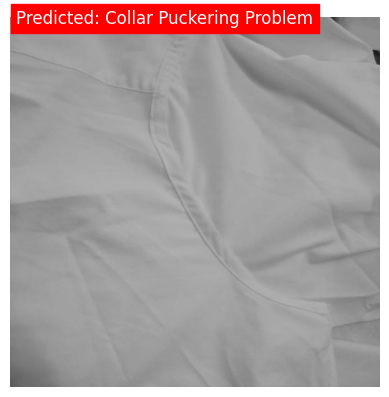

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()

#EfficientNet

##Setting EfficientNetB7

In [39]:
# Load the pre-trained ResNet-18 model
model = models.efficientnet_b7(pretrained=True)

# Freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:02<00:00, 115MB/s]


In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

##Setting up Training Loop

In [44]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for phase in ['train', 'valid']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training complete!")

train Loss: 7.1194 Acc: 0.0000
valid Loss: 8.2882 Acc: 0.0000
train Loss: 7.3257 Acc: 0.0000
valid Loss: 8.2001 Acc: 0.0000
train Loss: 6.9454 Acc: 0.0000
valid Loss: 8.1295 Acc: 0.0000
train Loss: 6.9290 Acc: 0.0000
valid Loss: 8.0809 Acc: 0.0000
train Loss: 7.0304 Acc: 0.0000
valid Loss: 7.9945 Acc: 0.0000
train Loss: 6.7945 Acc: 0.0000
valid Loss: 7.9237 Acc: 0.0000
train Loss: 6.7915 Acc: 0.0000
valid Loss: 7.8577 Acc: 0.0000
train Loss: 6.9907 Acc: 0.0000
valid Loss: 7.8230 Acc: 0.0000
train Loss: 6.9648 Acc: 0.0000
valid Loss: 7.7641 Acc: 0.0000
train Loss: 6.9177 Acc: 0.0000
valid Loss: 7.6982 Acc: 0.0000
Training complete!
